# 3D Hydro simulation with Volume penalization method
This notebook aims to show the workflow of setting up a 3D Hydro simulation with Volume penalization method in the cylindrical coordinates. ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X))

We pick the set up of example 1 from ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X)) as a showcase. The result would be slightly different from the  ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X)) since the IC setting is not excatly the same but we show similar result, which a vortex has been developed during simulation.

In [1]:
using MHDFlows,PyPlot,CUDA
using Statistics
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/2BZya/src/FourierFlows.jl:123


In [2]:
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [3]:
#parameters
N = 128;
Nz= 128;
Lx = 2π;

Re = 150;
Rₑ,Rᵢ = 0.82*pi,0.32*pi
L  = Rₑ - Rᵢ;
U  = 1;
ν  = U*L/Re
η  = ν;
dt = 5e-3;
# Testing the problem 
nothingfunction(args...) = nothing;
GPUprob = Problem(GPU();
        # Numerical parameters
                      nx = N,
                      Lx = 2π,
                      ny = N,
                      nz = Nz,
         # Drag and/or hyper-viscosity for velocity/B-field
                       ν = ν,
                      nν = 1,
                       η = η,
        # VP method
              VP_method = true,
        # Timestepper and equation options
                      dt = dt,
                 stepper = "RK4",
        # Force Driving parameters       
                   calcF = nothingfunction,
        # Float type and dealiasing
                       T = Float32)

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: ON
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [4]:
function Taylor_Couette_Cylindrical_Mask_Function(grid;R₂=0.82π,R₁=0.32π)
    nx,ny,nz = grid.nx,grid.ny,grid.nz;
    x,y,z = grid.x,grid.y,grid.z;
    S = BitArray(undef, nx,ny,nz);
    
    for k ∈ 1:nz, j ∈ 1:ny,i ∈ 1:nx
        xᵢ,yᵢ,zᵢ = x[i],y[j],z[k];
        Rᵢ       = √(xᵢ^2+yᵢ^2);
        # S = 0 if inside fluid domain while S = 1 in the solid domain 
        S[i,j,k] = (R₂ >= Rᵢ >= R₁) ?  0 : 1; 
    end    
    S
end

Taylor_Couette_Cylindrical_Mask_Function (generic function with 1 method)

In [5]:
function ProblemGeneratorTC3D!(prob;L0=2π,T=Float32)

  # Output Setting  
  x = Array(prob.grid.x);
  y = Array(prob.grid.y);
  z = Array(prob.grid.z);
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
  ux,uy,uz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);
  U₀x,U₀y,U₀z = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);  
  V₀ = 1;
  r₀ = 0.32π;  
    
  # Setup: Uθ = 1 if r ∈ 0.32π
  # Uθ =  r(dθ/dt) ê_θ
  # ̂e_θ  = - sinθ ̂i + cosθ ̂j; 
  χ =  Taylor_Couette_Cylindrical_Mask_Function(prob.grid;R₂=0.82π,R₁=r₀)
  for k ∈ 1:nz,j ∈ 1:ny,i ∈ 1:nx
    r = sqrt(x[i]^2+y[j]^2);
    θ = atan(y[j],x[i]) ;
    θ = isnan(θ) ? π/2 : θ
    sinθ = sin(θ);
    cosθ = cos(θ);
    #sinθ =  θ < 0 ? sin(-θ) : sin(θ)
    uz[i,j,k] =  ifelse(χ[i,j,k], 0,(rand(Float32,1)[1]-0.5)*1e-5);
    if r<=0.32π    
        ux[i,j,k] =  -r*sinθ;
        uy[i,j,k] =   r*cosθ;
        U₀x[i,j,k] = -r*sinθ;
        U₀y[i,j,k] =  r*cosθ;  
    end        
  end
  
  # Crypto data  
  copyto!(prob.vars.ux, deepcopy(ux));
  copyto!(prob.vars.uy, deepcopy(uy));
  copyto!(prob.vars.uz, deepcopy(uz));

    
  copyto!(prob.params.χ, Array(χ));
  copyto!(prob.params.U₀x, U₀x);
  copyto!(prob.params.U₀y, U₀y);  
  copyto!(prob.params.U₀z, U₀z);    
    
  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
      
  return nothing
end

ProblemGeneratorTC3D! (generic function with 1 method)

In [6]:
# Setting up the Initial condition for both domain
ProblemGeneratorTC3D!(GPUprob);
Ux,Uy = Array(GPUprob.params.U₀x),Array(GPUprob.params.U₀y);
Ur,Uθ = xy_to_polar(Ux,Uy);

## The Solid Domain and Initial condition illustration

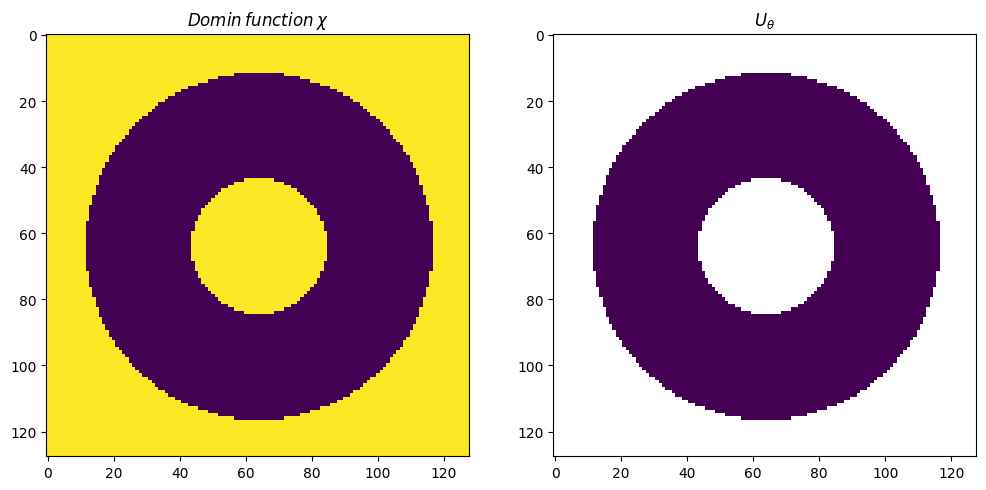

In [7]:
A  = ones(size(Ux));
χ = Array(GPUprob.params.χ);
A[χ.==1].=NaN;
figure(figsize=(12,6))
subplot(121);
imshow(χ[:,:,1]);
title(L"Domin\:function\:\chi");
subplot(122);
imshow((A.*Uθ)[:,:,1]);
title(L"U_\theta");

In [8]:
# Set up the initial condition
TimeIntegrator!(GPUprob,200.0,50000;
                   usr_dt = dt,
                    diags = [],
              loop_number = 1000,
                     save = false,
                 save_loc = "",
                 filename = "",
                  dump_dt = 0)

n =     1000, t =      5.0, KE =     15.5
n =     2000, t =     10.0, KE =     17.9
n =     3000, t =     15.0, KE =     19.6
n =     4000, t =     20.0, KE =     21.0
n =     5000, t =     25.0, KE =     22.2
n =     6000, t =     30.0, KE =     23.3
n =     7000, t =     35.0, KE =     24.2
n =     8000, t =     40.0, KE =     24.9
n =     9000, t =     45.0, KE =     25.5
n =    10000, t =     50.0, KE =     26.0
n =    11000, t =     55.0, KE =     26.5
n =    12000, t =     60.0, KE =     26.8
n =    13000, t =     65.0, KE =     27.1
n =    14000, t =     70.0, KE =     27.3
n =    15000, t =     75.0, KE =     27.5
n =    16000, t =     80.0, KE =     27.7
n =    17000, t =     85.0, KE =     27.8
n =    18000, t =     90.0, KE =     27.9
n =    19000, t =     95.0, KE =     28.0
n =    20000, t =    100.0, KE =     28.0
n =    21000, t =    105.0, KE =     28.1
n =    22000, t =    110.0, KE =     27.9
n =    23000, t =    115.0, KE =     27.4
n =    24000, t =    120.0, KE =  

# illustration of the result

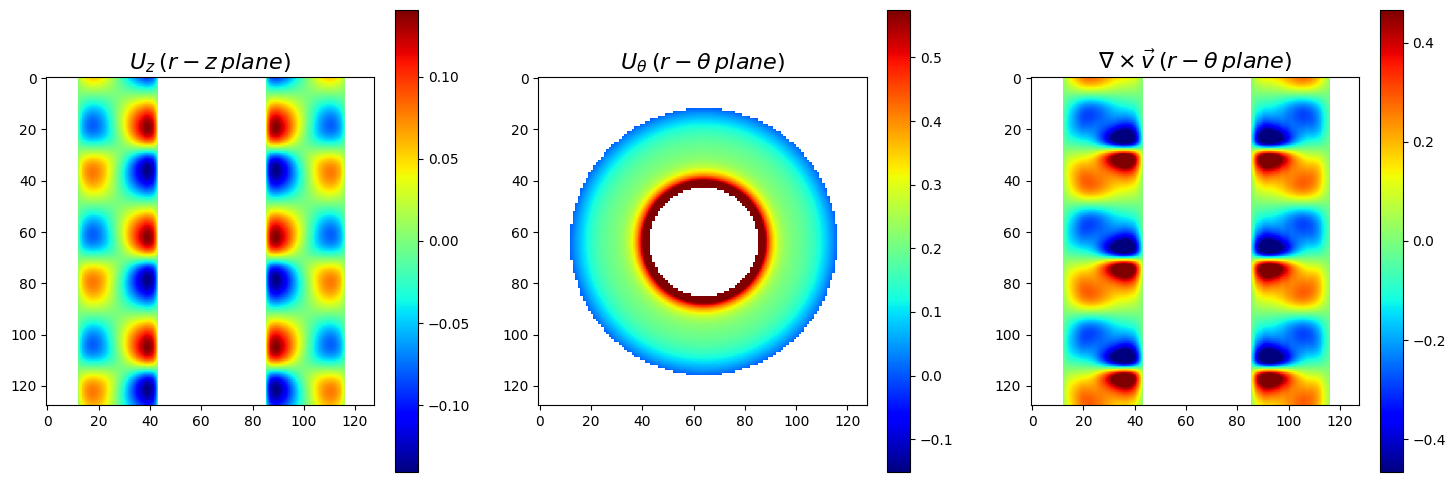

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4714a88b00>

In [9]:
iv,jv,kv = Array(GPUprob.vars.ux),Array(GPUprob.vars.uy),Array(GPUprob.vars.uz);
Ur,Uθ = xy_to_polar(iv,jv);

figure(figsize=(18,6))

subplot(131)
imshow((A.*kv)[:,64,:]',cmap="jet");colorbar();
title(L"U_z\:(r-z\:plane)",size=16)


subplot(132)
title(L"U_\theta\:(r-\theta\:plane)",size=16)
Uθ2D = (A .*Uθ)[:,:,1];
meanTA = mean(Uθ2D[.~isnan.(Uθ2D)]);
stdTA  =  std(Uθ2D[.~isnan.(Uθ2D)]);
imshow(Uθ2D,vmin=meanTA-2stdTA,vmax=meanTA+2stdTA,cmap="jet");colorbar()


subplot(133)
title(L"\nabla\times \vec{v} \:(r-\theta\:plane)",size=16)
civ,cjv,ckv = Curl(iv,jv,kv);
cUr,cUθ = xy_to_polar(civ,cjv);
cUr2D = (A .*cUr)[:,64,:]';
meanTA = mean(cUr2D[.~isnan.(cUr2D)]);
stdTA  =  std(cUr2D[.~isnan.(cUr2D)]);
imshow(cUr2D,vmin=meanTA-2stdTA,vmax=meanTA+2stdTA,cmap="jet");colorbar()